# Preprocesamiento
***
## Leer y procesar base de datos

De la base de datos tenemos la siguiente información sobre los atributos:
   1. __survival__: número de meses que el paciente ha sobrevió o ha sobrevivido si sigue vivo. Como todos los pacientes tuvieron infartos en diferentes edades, es posible que unos hayan sobrevivido menos del año pero siguen vivos. Revise la segunda variable para verificarlo. Tales pacientes no pueden ser utilizados para la tarea de predicción.
   2. __still-alive__: variable binaria.  0 significa muerte tras el periodo de supervivencia, 1 significa que sigue vivo
   3. __age-at-heart-attack__: edad en años de la ocurrencia del infarto
   4. __pericardial-effusion__: binario. Efusión pericardial es fluido alrededor del corazón.  0=sin fluido, 1=con fluido
   5. __fractional-shortening__: una medida de la contractibilidad alrededor del corazón, números bajos son incrementalmente anormales.
   6. __epss__: E-point septal separation, otra medida de contractibilidad. Números altos son incrementalmente anormales.
   7. __lvdd__: left ventricular end-diastolic dimension. Esta es una medida del tamaño del corazón en la diastólica. Corazones grandes tienden a estar enfermos.
   8. __wall-motion-score__: una medida de cómo se están moviendo los segmentos del ventrículo izquierdo.
   9. __wall-motion-index__: igual a wall-motion-score dividido por el número de segmentos vistos. Usualmente 12-13 segmentos son vistos en un ecocardiograma Use esta variable EN LUGAR DE wall-motion-score.
   10. __mult__: una variable derivada que puede ser ignorada.
   11. __name__: el nombre del paciente (He reemplazado con "name").
   12. __group__: irrelevante, ignórela.
   13. __alive-at-1__: boleano. Derivado de los primeros dos atributos. 0 significa que el paciente o estaba muerto después de un año o fue seguido per menos de un año.  1 significa que el paciente estaba vivo al año.


Leemos el archivo `*.data` y lo guardamos en un *data frame*

In [1]:
import pandas as pd
from numpy import genfromtxt, zeros

names = ['survival', 'still_alive', 'age_at_heart_attack', 'pericardial_effusion',
         'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score',
         'wall_motion_index', 'mult', 'name', 'group', 'alive_at_1']
data = pd.DataFrame(genfromtxt('../data/echocardiogram.data', delimiter=','), columns=names)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
survival                 130 non-null float64
still_alive              131 non-null float64
age_at_heart_attack      127 non-null float64
pericardial_effusion     131 non-null float64
fractional_shortening    124 non-null float64
epss                     117 non-null float64
lvdd                     121 non-null float64
wall_motion_score        128 non-null float64
wall_motion_index        131 non-null float64
mult                     128 non-null float64
name                     0 non-null float64
group                    110 non-null float64
alive_at_1               74 non-null float64
dtypes: float64(13)
memory usage: 13.5 KB
None


Como vemos no todas las columnas son útiles debido a la falta de valores, como la columna `names` que no contiene un solo valor de utilidad. Así eliminamos las columnas `'wall_motion_score', 'mult', 'name', 'group'`.
 - La primera porque el autor lo indica.
 - Las siguientes tres no contienen información nueva o relevante.
 
Además, hay pacientes que tienen un seguimiento menor al año pero siguen vivos. Descartamos estos pacientes pues (como lo indica la información del autor) no pueden ser utilizados para la tarea en mano.

In [2]:
data.drop(['wall_motion_score', 'mult', 'name', 'group'], axis=1, inplace=True)
indexNames = data[ (data['survival'] < 12) & (data['still_alive'] == 1) ].index
data.drop(indexNames, inplace=True)

Nos interesa la información de la última columna `alive_at_1` pero está incompleta. Utilizamos la información de la primera columna para completarla. No consideramos la segunda pues ya contamos con todos los pacientes que han tenido un período de seguimiento mayor a 12 meses si es que sobrevivieron. Todos los pacientes con `survival`$<12$ se les asigna 0, y 1 en caso contrario.

In [3]:
for i in range( len(data['survival'].values) ):
    if (data['survival'].values[i] < 12):
        data['alive_at_1'].values[i] = 0
    else:
        data['alive_at_1'].values[i] = 1

Eliminamos las columnas `survival` y `still_alive`, pues ya no las necesitamos, al igual que todas las __instancias__ que contienen `NaN`.

In [4]:
data.drop(['survival', 'still_alive'], axis=1, inplace=True)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
display(data)
data['alive_at_1'].value_counts()

,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,alive_at_1
0,71.0,0.0,0.260,9.000,4.600,1.000,0.0
1,72.0,0.0,0.380,6.000,4.100,1.700,1.0
2,55.0,0.0,0.260,4.000,3.420,1.000,1.0
3,60.0,0.0,0.253,12.062,4.603,1.450,1.0
4,57.0,0.0,0.160,22.000,5.750,2.250,1.0
...,...,...,...,...,...,...,...
78,61.0,0.0,0.140,25.500,5.160,1.270,1.0
79,64.0,0.0,0.280,5.400,5.470,1.100,1.0
80,69.0,0.0,0.200,7.000,5.050,1.210,1.0
81,57.0,0.0,0.140,16.100,4.360,1.360,1.0


1.0    80
0.0     3
Name: alive_at_1, dtype: int64

Se observa que hay tres casos de fallecimiento antes del año.
***
Graficamos la base de datos para ver posibles relaciones lineales entre atributos. En el siguiente *pairplot* utilizamos la columna `alive_at_1` como escala de color y graficamos sólo las columnas con valores no binarios para poder apreciar mejor alguna distribución.

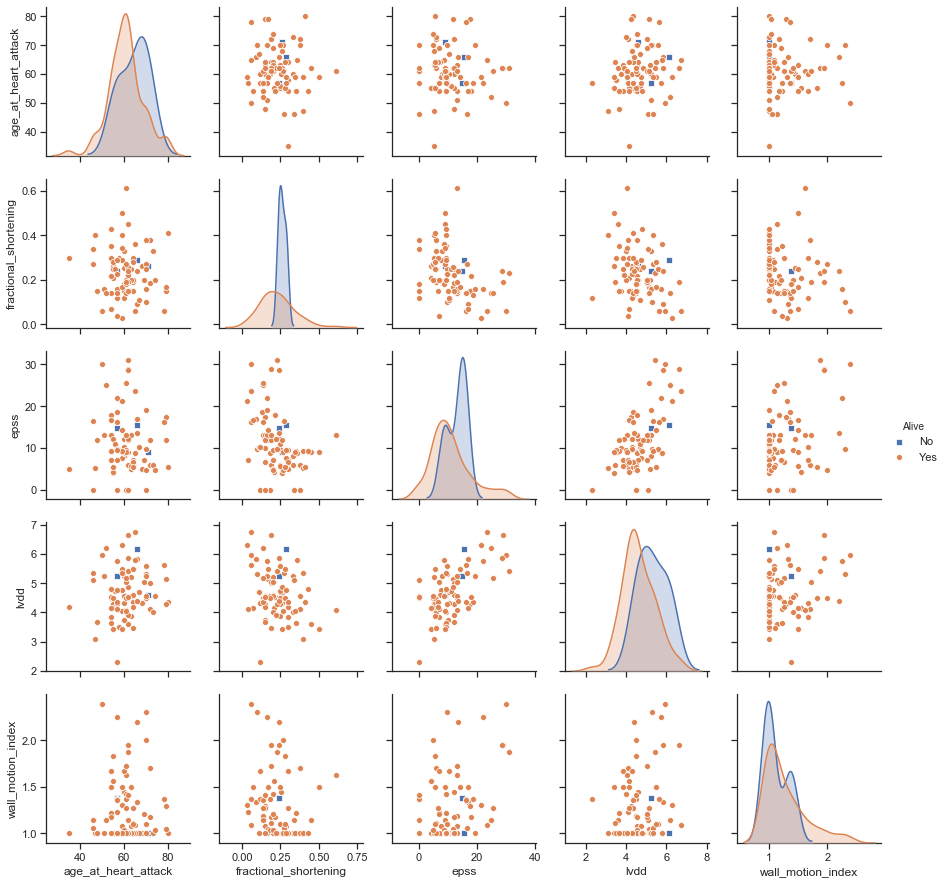

In [5]:
# Plot data_frame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="ticks")
s = sns.pairplot(data, hue='alive_at_1', markers=["s", "o"], vars=['age_at_heart_attack',
                                                                   'fractional_shortening',
                                                                   'epss', 'lvdd', 'wall_motion_index'])

new_title = 'Alive'              # Change legend label
s._legend.set_title(new_title)
new_labels = ['No', 'Yes']

for t, l in zip(s._legend.texts, new_labels):
    t.set_text(l)
plt.show();

No se logra apreciar alguna separación de datos en ningún gráfico, por lo que utilizaremos todas las columnas como entrada.
***
## Preparar datos para entrenamiento

Como nos interesa saber si el paciente vivirá más del año, la columna `alive_at_1` contiene las etiquetas de las categorías (**labels**). Transformamos esta columna en un arreglo de la forma `[batch_size, class_number]`, donde **batch** (lote) será el total de datos. Cada elemento del arreglo es de la forma `[1,0]` si el paciente **murió**, o bien `[0,1]` si el paciente **sobrevivió**.

Podemos darle al modelo todas las instancias a la vez porque contamos con pocas. De contar con varios cientos o incluso miles de instancias, conviene separar la muestra de entrenamiento en varios lotes. 

In [6]:
from sklearn.model_selection import train_test_split

column_names = data.columns.values
x = data[column_names[:-1]]
y = data[{column_names[-1]}]

batch_size = len(x)
class_number = 2
temp = zeros((batch_size, class_number), int)
for i in range(batch_size):
    if y.values[i]==0:  # First column is dead
        temp[i,0] = 1
    else:
        temp[i, 1] = 1
y = temp

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

El número de nodos de entrada (o neuronas de paso) será igual al número de atributos (columnas en x), i.e. seis. Luego proponemos una red pequeña con una capa oculta con 4 neuronas; y dos en la salida, cada una correspondiente a una clase. Especificamos además una tasa de aprendizaje (para el algoritmo de optimización que veremos adelante).

In [7]:
n_input = 6     # input layer (6 columns/features)
n_hidden1 = 4   # hidden layer
n_output = 2    # output layer (alive after a year)

learning_rate = 1e-3

***
# Modelado
En **<font color=red>TensorFlow</font>**, al declarar variables y métodos, estos <font color=green> no son evaluados *in situ* </font> al estilo Python, sino que reserva los *nombres* y *tipos* relacionados a ellos. No es hasta que se corre una **sesión** que las variables son llenadas con el entrenamiento. En el siguiente bloque de código se declaran las variables y las operaciones que se realizarán con ellas durante el entrenamiento, así como los parámetros: precisión (**accuracy**) y costo o pérdida (**loss**).
***
## Declarar modelo

Lo primero es declarar marcadores de posición para el conjunto de entrenamiento `X` y el conjunto de etiquetas `Y`. Como no conocemos *a priori* el número de instancias por lote debemos dejar sin especificar la longitud de la primer dimensión del arreglo. Ésto se logra con un `None`, que será cambiado por `len(X)` una vez que se alimente el conjunto de datos al modelo. En este caso tenemos seis atributos por instancia y una entrada por atributo (`X` es un tensor de rango 2) por lo que debemos especificar que la segunda dimensión contiene un número de entradas igual al número de neuronas en la primer capa. De este modo la forma de `X` es `[None, n_input] = (?,6)`. Hacemos lo mismo para `Y` que tendrá la forma `[None, n_output] = (?,2)`.

In [8]:
import tensorflow as tf

X = tf.compat.v1.placeholder(tf.float32, [None, n_input])
Y = tf.compat.v1.placeholder(tf.float32, [None, n_output])

En un MLP cada capa está completamente conectada con la siguiente (*fully connected*). El número de pesos (**weights**) debe corresponder al número de conexiones entre neuronas. Declaramos un conjunto de pesos por cada par de capas con distribución gaussiana $N(\mu=0, \sigma=0.1)$. Para este caso tendremos dos conjuntos: entrada — oculta, oculta — salida. Cada conjunto de pesos es un arreglo de dos dimensiones en congruencia con las dimensiones de las capas que conecta. El primer conjunto debe tener la forma `[6,4]` y el segundo `[4,2]`. Además, agregamos un sesgo (**bias**) constante a cada capa con el mismo número de neuronas que la capa a la que conecta, i.e. un sesgo con forma `[4]` entre entrada — oculta, y otro con forma `[2]` entre oculta — salida.

In [9]:
with tf.name_scope('weights'):
    weights = {
        'w1': tf.Variable(tf.random.normal([n_input, n_hidden1], stddev=0.1)),
        'out': tf.Variable(tf.random.normal([n_hidden1, n_output], stddev=0.1)),
    }

with tf.name_scope('biases'):
    biases = {
        'b1': tf.Variable(tf.constant(1., shape=[n_hidden1])),
        'out': tf.Variable(tf.constant(1., shape=[n_output]))
    }

Ahora declaramos las operaciones entre capas. Como se trata de perceptrones la función de objetivo es lineal $XW+B$ en todas las capas.

In [10]:
layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
output_layer = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])

La función de pérdida utilizada es **sofmax** con **cross entropy loss** (pérdida de entropía cruzada). A continuación se explica cada una de ellas.

<div class="alert alert-block alert-info">
<b>Softmax:</b> La función **Softmax** $\sigma:\mathbb{R}^{N}\rightarrow\mathbb{R}^{N}$ toma un vector N-dimensional de números reales $\mathbf{z}=(z_1,\dots,z_N)\in\mathbb{R}^{N}$ y lo transforma en un vector de valor real en el rango (0,1) cuya suma de elementos da 1. $$\sigma_i(\mathbf{z}) = \dfrac{e^{z_i}}{\sum e^{z_j}}$$ En lugar de tomar el valor máximo, el máximo valor se lleva la mayor porción de la distribución. Esta propiedad de la función softmax, que da una distribución de probabilidad la hace makes it adecuada para interpretación probabilistica en tareas de clasificación.

Para hacer la función numéricamente estable se normaliza el vector multiplicando por una constante $C$, lo que nos transforma la función a $$\sigma(\mathbf{z})_i = \dfrac{e^{z_i+\log(C)}}{\sum e^{z_j+\log(C)}}$$ donde generalmente se toma $\log(C)=-\max(z_i)$.

La derivada de la función softmax está dada por $$\dfrac{\partial \sigma_i}{\partial z_j} = \sigma_i\left(\delta_{ij}-\sigma_j\right)$$
</div>
<div class="alert alert-block alert-info">
<b>Pérdida de entropía cruzada (Cross Entropy Loss):</b> Ésta indica la distancia entre lo que el modelo cree que la distribución de salida debe ser y lo que la distribución original realmente es. Se define como $$H(y,p)=−\sum_i^{M} y_i \log(p_i)$$ donde $M$ es el número de clases, $y_i$ es un binario indicando si la clase predecida es correcta (cero) o no (uno), y $p_i$ es la probabilidad predecida de que la observación sea de la clase predecida. Es utilizada cuando la activación de nodos puede entenderse como representación de la probabilidad de que cada hipótesis sea verdadera, i.e. cuando la salida es una distribución de probabilidad. Por lo tanto es utilizada como función de pérdida cuando la capa de salida tiene activación softmax.

Tomando la función softmax como $p_i=\sigma_i(\mathbf{z})$ como activación, calculamos la derivada de la función de pérdida de entropía cruzada con softmax, lo que nos lleva a $$\dfrac{\partial H}{\partial z_j} = \sigma_i-y_i$$ la cual es una relación simple y elegante.
</div>

Finalmente reducimos la función de pérdida con la media de las pérdidas de cada instancia procesada.

In [11]:
loss_function = tf.reduce_mean( tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=output_layer))

Ya definida la función de pérdida debemos decirle al modelo de qué manera converja al mínimo local del espacio paramétrico de los pesos. Aquí usaremos el algoritmo Adam

<div class="alert alert-block alert-info">
<b>Algorimo ADAM (optimización de pesos):</b>
Computa tasas de aprendizaje adaptativas individuales para distintos parámetros a partir de estimaciones del primer y segundo momento de los gradicentes (media y varianza descentralizada). Esto es que combina los métodos de *Adaptative Gradient* (AdaGrad) y *Root Mean Square Propagation* (RMSProp). Los parámetros del algoritmo son: la tasa de aprendizaje $\ell_t$; y las tasas de decaimiento exponencial del primer y segundo momento, $\beta_1,~\beta_2$ respectivamente. La actualización de valores para la variable $w$ con gradiente $g$ se realiza de la siguiente manera

$$\begin{aligned}\ell_t & := \ell\dfrac{\sqrt{1-\beta_2}}{1-\beta_1} \\
m_t & := \beta_1 m_{t-1} + \left(1-\beta_1\right)g \\
v_t & := \beta_2 v_{t-1} + \left(1-\beta_2\right)g^2 \\
w & := w - \ell_t\dfrac{m_t}{\sqrt{v_t} + \epsilon}\end{aligned}$$
</div>

Los valores predeterminados en la clase de TensorFlow son $\ell=0.001,~\beta_1=0.9,~\beta_2=0.999$. Más aún debemos especificar cual función es a la que calculará los gradientes con el método `minimize(loss=loss_function)`.

In [12]:
optimizer_adam = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss_function)

Por último definimos el parámetro que nos dará precisión de predicción del modelo. Primero buscamos el elemento en la capa de salida con el valor máximo a lo largo de el eje 1 (`tf.argmax(val, 1)`) y lo comparamos el con máximo de la predicción. Ésto nos arroja un arreglo con valores binarios que luego reducimos con la media de las predicciones correctas, lo cual nos da un valor en el intervalo (0,1).

In [13]:
correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Hasta este punto, todos los elementos del modelo junto con parámetros informativos del entrenamiento han quedado declarados
***
## Entrenamiento

Preparamos un resumen informativo que alojaremos en <font color=orange>Tensorboard</font>. 

In [14]:
cost_summary = tf.compat.v1.summary.scalar("Cost", loss_function)
acc_summary = tf.compat.v1.summary.scalar("Accuracy", accuracy)
all_summary = tf.compat.v1.summary.merge_all()

TensorFlow tabaja en sesiones las cuales, bajo el método `run(fetches=, feed_dict=)` realizan *pasos* de cómputo, corriendo los fragmentos de *gráfica* (un cómputo de TensorFlow, representado como gráfica de flujo de datos) necesarios para ejecutar cada __Operación__ y evaluar cada __Tensor__ en `fetches`, sustituyendo los valores en `feed_dict` por los valores correspondientes de entrada.

<div class="alert alert-block alert-warning">
<b>Ejemplo:</b> Supongamos que `xx` es lote con diez instancias del total de observaciones con `yy` sus correspondientes etiquetas. Si alimentamos a la sesión con el diccionario `{X: xx, Y: yy}`, un sólo paso revisará entonces una sola vez a las diez instancias contenidas en `X` y actualizará los pesos para estas observaciones. Si volvemos a correr la sesión, la cual contiene los pesos actualizados de la primera corrida, volverá a actualizar los pesos para las mismas observaciones ajustando así mejor a los datos del diccionario.</div>

Cada iteración completa sobre los datos de entrenamiento se llama __época__. Entre mayor número de épocas corra la sesión, mejor será el ajuste a las observaciones, que eventualmente lleva a la convergencia.

In [15]:
n_epochs = 200

Iniciamos una **sesión de TensorFlow** con las variables globales e indicamos que guarde las *gráficas* (de Tensorboard) y resúmenes generados en una carpeta llamada "Tensorboard". Correremos `n_epochs` veces la sesión en la cual le damos la operación que definimos `fetches=optimizer_adam` y alimentamos un diccionario con los datos de entrenamiento `{X: x_train, Y: y_train}`.

Por razones de monitoreo imprimos en pantalla el progreso del costo y la precisión cada 100 épocas. En este caso los *fetches* serán las operaciones: resumen, costo y precisión.

In [16]:
init = tf.compat.v1.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)
writer = tf.summary.FileWriter("Tensorboard", sess.graph)
for i in range(n_epochs):
    sess.run(optimizer_adam, feed_dict={X: x_train, Y: y_train})
    if i % 10 == 0:
        summary_results, loss, acc = sess.run([all_summary, loss_function, accuracy], 
                                              feed_dict={X: x_train, Y: y_train})
        print(f"Iteration {i} \t| Loss = {loss:7.5f} \t| Accuracy = {acc:7.5f}")
        writer.add_summary(summary_results, i)

Iteration 0 	| Loss = 1.54165 	| Accuracy = 0.01515
Iteration 10 	| Loss = 0.86115 	| Accuracy = 0.03030
Iteration 20 	| Loss = 0.46376 	| Accuracy = 0.98485
Iteration 30 	| Loss = 0.27035 	| Accuracy = 0.98485
Iteration 40 	| Loss = 0.18174 	| Accuracy = 0.98485
Iteration 50 	| Loss = 0.13958 	| Accuracy = 0.98485
Iteration 60 	| Loss = 0.11783 	| Accuracy = 0.98485
Iteration 70 	| Loss = 0.10557 	| Accuracy = 0.98485
Iteration 80 	| Loss = 0.09810 	| Accuracy = 0.98485
Iteration 90 	| Loss = 0.09327 	| Accuracy = 0.98485
Iteration 100 	| Loss = 0.08999 	| Accuracy = 0.98485
Iteration 110 	| Loss = 0.08769 	| Accuracy = 0.98485
Iteration 120 	| Loss = 0.08605 	| Accuracy = 0.98485
Iteration 130 	| Loss = 0.08485 	| Accuracy = 0.98485
Iteration 140 	| Loss = 0.08397 	| Accuracy = 0.98485
Iteration 150 	| Loss = 0.08332 	| Accuracy = 0.98485
Iteration 160 	| Loss = 0.08282 	| Accuracy = 0.98485
Iteration 170 	| Loss = 0.08245 	| Accuracy = 0.98485
Iteration 180 	| Loss = 0.08216 	| Accu

***
Finalmente corremos el modelo con los datos de prueba (o validación en este caso).

In [17]:
test_accuracy = sess.run(accuracy, feed_dict={X: x_test, Y: y_test})
print("\nAccuracy on test set:", test_accuracy)


Accuracy on test set: 0.88235295


La evolución de la precisión creciente y converge al 98.5%, mientras que la pérdida o costo es siempre decreciente y logra estabilizarse (aquí el valor no es relevante como lo es el comportamiento).

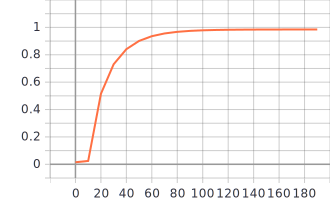

In [18]:
from IPython.core.display import SVG
SVG(filename='Accuracy.svg')

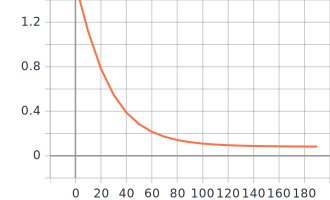

In [19]:
SVG(filename='Cost.svg')